# Cohabit & marriage impact analysis - ML based causal impact analysis

## Notebook objective
   * Conduct causal impact analysis using ML (meta-learner) methods. 
   * The decided estimand is as follows: 
      * __In US national longitudinal survey (NLS) 97 respondents, what is the <span style="color:green"> probability difference to scoring 8 or higher (i.e. sig. chance in having depression)</span> in the 2021 survey between the respondents that are married VS never married at the time of the survey?__


## Results summary
   * 


## Notes
   * We will mainly be using DoWhy (and econML) for the ML-based causal analysis. 
   * There are some minor configurations that were tested for each round, but not stored as separate results. 
   

## Imports

In [5]:
import pandas as pd
from io import StringIO
import re
from itables import init_notebook_mode
from itables import show
import pickle

import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import chi2_contingency
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu
from sklearn.neighbors import NearestNeighbors

from econml.metalearners import SLearner
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
import dowhy
from dowhy import CausalModel
from dowhy import gcm
import networkx as nx

from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import mean_squared_error

## Data preprocess (same as nonml)

In [7]:
target_year = 2019
target_outcome = 'CESD_above_8'
target_treatment = 'married_vs_never_married'

In [8]:
def better_colnames(df, from_col: str, to_cols: list[str]  = ['Description','Year']):
    ''' Helper function to rename the columns in the (NLS data) df into something readable/helpful, based on data in codebook_df
    '''
    #Create dataframe with Ref column and the desired new column names based on input
    col_mapping = pd.concat([codebook_df[from_col],codebook_df[to_cols[0]].str.cat(codebook_df[to_cols[1:]],sep='_')],axis=1)    
    col_mapping.columns.values[1] = '_'.join(to_cols)
    #Convert the mapping dataframe to dictionary and rename columns
    return(df.rename(columns = col_mapping.set_index(from_col).squeeze().to_dict()))

In [9]:
tidy_df= pd.read_pickle('temp/tidy_df.pkl')
main_df= pd.read_pickle('temp/main_df.pkl')
codebook_df= pd.read_pickle('temp/codebook_df.pkl')
mental_health_df= pd.read_pickle('temp/mental_health_df.pkl')
codebook_df= pd.read_pickle('temp/codebook_df.pkl')
cohab_mhealth_df = pd.read_pickle('temp/cohab_mhealth_df.pkl')
source_df = pd.read_pickle('temp/source_df.pkl')
partner_df = pd.read_pickle('temp/partner_df.pkl')
marriage_stats_df = pd.read_pickle('temp/marriage_stats_df.pkl')
interview_df = pd.read_pickle('temp/interview_df.pkl')


In [10]:
#Model data creation

tidy_df_cols = {
    'uid': 'uid',
    'sex': 'sex',
    'age_1996': 'age_1996',
    'hispanic': 'hispanic',
    'race': 'race',
    'CV_URBAN_RURAL': 'urban',
    'CV_HH_SIZE': 'household_size',
    'CV_INCOME_FAMILY': 'household_income',
    'CV_HH_POV_RATIO': 'pov_ratio',
    'YHEA_1005': 'limited_work_kind',
    'YHEA_1006': 'limited_work_amt',
    'BIOADOPTCHILD_ADOPTED.01': 'child_1_adopted', #This can also tell if respondent has a child
    
}
source_df_cols = {
    'S1235200': 'asthma_2002',
    'S1235201': 'heart_2002',
    'S1235202': 'anemia_2002',
    'S1235203': 'diabetes_2002',
    'S1235204': 'cancer_2002',
    'S1235205': 'epilepsy_2002',
    'S1235206': 'hiv_aids_2002',
    'S1235207': 'std_2002',
    'S1235208': 'chronic_other_2002',
    'Z9083900': 'highest_degree',
    'R0534000': 'nonresp_parent_in_HH',
    'R1204500': 'hh_income_1997',
    'R0689000': 'pct_college_by_30',
    'R2182500': 'date_male_1998',
    'R2182000': 'date_female_1998',    
    'R0073000': 'num_days_homework'
}

#Initially add columns from tidy_df 
model_data_df = tidy_df.loc[tidy_df['Year'] == target_year,list(tidy_df_cols.keys()),]

#Add source_df columns
model_data_df = model_data_df.merge(source_df.loc[:,['uid'] + list(source_df_cols.keys())],on='uid')


#Add derived columns from previous work
cohab_mhealth_cols = ['uid','Rxx_CESD_SCORE_(x_ITEM)','married',target_outcome]
model_data_df = model_data_df.merge(cohab_mhealth_df.loc[cohab_mhealth_df['Year']==2019,cohab_mhealth_cols],on='uid')
model_data_df = model_data_df.rename(columns={'Rxx_CESD_SCORE_(x_ITEM)':'CESD'})


#converting the main treatments and outcome to int
#Since there are three states (Married, Not married but married before, Never married), we will create two separate columns 
model_data_df['CESD_above_8'] = model_data_df['CESD_above_8'].astype(int)
model_data_df['married_vs_not_married'] = (model_data_df['married'] == 'Yes').astype(int)
model_data_df['married_vs_never_married'] = (model_data_df['married'] == 'Yes').astype(int)
#For married VS never married, the "Married but married before" respondents will be marked as NaN
model_data_df.loc[model_data_df['married']=='No',['married_vs_never_married']] = np.nan

model_data_df.rename(columns=tidy_df_cols,inplace=True)
model_data_df.rename(columns=source_df_cols,inplace=True)

In [11]:
# Currently a lot of the columns are stored as sparse data. Some models choke as they don't handle such datatype. 
# Therefore, changing them to dense

def dense_columns(col):
    if (isinstance(col.dtype, pd.SparseDtype)): 
        return col.sparse.to_dense()
    else:
        return col
    
model_data_df = model_data_df.apply(dense_columns,axis=0)

In [12]:
#Create BMI columns. Since height and weight not mentioned every year, need to pull from last known

#Get index for last known weight and height 
last_known_wgt_idx = tidy_df.loc[(tidy_df['YSAQ_000B'].notnull()) & (tidy_df['YSAQ_000B'] > 0),:].groupby('uid')['YSAQ_000B'].idxmax()
last_known_hgt_idx = tidy_df.loc[(tidy_df['YSAQ_000A000001'].notnull()) & (tidy_df['YSAQ_000A000001'] > 0)
                                 & (tidy_df['YSAQ_000A000002'].notnull()) & (tidy_df['YSAQ_000A000002'] >= 0)
                                 ,:].groupby('uid')['YSAQ_000A000001'].idxmax()


#Using the values above, get bmi
bmi_df = tidy_df.loc[last_known_wgt_idx,['uid','YSAQ_000B']]
bmi_df = bmi_df.merge(tidy_df.loc[last_known_hgt_idx,['uid','YSAQ_000A000001','YSAQ_000A000002']],on='uid',how='left')
bmi_df['bmi'] = bmi_df['YSAQ_000B'] / ((bmi_df['YSAQ_000A000001'] * 12 + bmi_df['YSAQ_000A000002']) ** 2) * 703
bmi_df['bmi'] = bmi_df['bmi'].sparse.to_dense()

model_data_df.drop(['bmi','bmi_bin'],inplace=True,errors='ignore')
model_data_df = model_data_df.merge(bmi_df[['uid','bmi']], on='uid',how='left')

#Imputing bmi based on US average. Technically the average is different per male and female, but it's slight difference
# (29.1 VS 29.6) so just using the same value.
model_data_df['bmi'] = model_data_df['bmi'].fillna(29.4)

#There is one person with weight of 999. Assuming that's by error. Using average
model_data_df.loc[model_data_df['uid'] == 5707,'bmi'] = 29.4

#Create bin
model_data_df['bmi_bin'] = ''
model_data_df.loc[model_data_df['bmi'] < 18.5,'bmi_bin'] = 'under'
model_data_df.loc[model_data_df['bmi'].between(18.5, 25.0,inclusive='left'),'bmi_bin'] = 'normal'
model_data_df.loc[model_data_df['bmi'].between(25.0, 29.0,inclusive='left'),'bmi_bin'] = 'over'
model_data_df.loc[model_data_df['bmi'] > 29.0,'bmi_bin'] = 'obese'
model_data_df['bmi_bin'] = model_data_df['bmi_bin'].astype('category')

In [13]:
#Flipping urban variable values (0:rural 1:urban 2:unknown) to somewhat more ordinal (0:unknown 1:rural 2:urban)
model_data_df['urban'].fillna(0,inplace=True)
model_data_df.loc[model_data_df['urban'] < 0,'urban'] = 2
model_data_df['urban'] = model_data_df['urban'].map({0:1,1:2,2:0})

In [14]:
#Put any NaNs or negative values to zero
model_data_df['household_income'].fillna(0,inplace=True)
model_data_df.loc[model_data_df['household_income'] < 0, 'household_income'] = 0
#Log transform income
model_data_df['household_income_log'] = np.log(model_data_df['household_income'] + 1) 

model_data_df.loc[model_data_df['limited_work_kind'] < 0, 'limited_work_kind'] = 0
model_data_df.loc[model_data_df['limited_work_kind'] < 0, 'limited_work_kind'] = 0



model_data_df.loc[model_data_df['pov_ratio'] < 0, 'pov_ratio'] = 0

# Create a column for having a child or not. 
# One concern. This may not mean the child is still alive, which may negatively effect the mental health
model_data_df['has_child'] = (model_data_df['child_1_adopted'] < 0).astype(int)


In [15]:
model_data_df.loc[model_data_df['asthma_2002'] < 0, 'asthma_2002'] = 0
model_data_df.loc[model_data_df['heart_2002'] < 0, 'heart_2002'] = 0
model_data_df.loc[model_data_df['anemia_2002'] < 0, 'anemia_2002'] = 0
model_data_df.loc[model_data_df['diabetes_2002'] < 0, 'diabetes_2002'] = 0
model_data_df.loc[model_data_df['cancer_2002'] < 0, 'cancer_2002'] = 0
model_data_df.loc[model_data_df['epilepsy_2002'] < 0, 'epilepsy_2002'] = 0
model_data_df.loc[model_data_df['hiv_aids_2002'] < 0, 'hiv_aids_2002'] = 0
model_data_df.loc[model_data_df['std_2002'] < 0, 'std_2002'] = 0
model_data_df.loc[model_data_df['chronic_other_2002'] < 0, 'chronic_other_2002'] = 0

In [16]:
#For highest educational degree, there were few that refused to answer (-3). For them, setting as high school diploma (2)
model_data_df.loc[model_data_df['highest_degree'] < 0, 'highest_degree'] = 2

In [17]:
# Create log transform version of hh_income_1997. 
model_data_df['hh_income_1997_log'] = np.log(model_data_df['hh_income_1997'].map(lambda x: x if x > 0 else 0)+ 1) 

#Set negative values to NaNs
model_data_df.loc[model_data_df['pct_college_by_30'] < 0,'pct_college_by_30'] = np.nan
model_data_df.loc[model_data_df['num_days_homework'] < 0,'num_days_homework'] = np.nan


#combine date male and female 
model_data_df['date_1998'] = model_data_df.loc[:,['date_male_1998','date_female_1998']].max(axis=1)
model_data_df['date_1998'] = model_data_df['date_1998'].map(lambda x: x if x > 0 else 0)


In [18]:
#Get number of months married based on the interview year-month
temp_df = interview_df.loc[interview_df['Year']==target_year,:]
temp_df = temp_df.merge(marriage_stats_df,on='uid')
temp_df = temp_df.loc[(temp_df['marriage_start'] <= temp_df['interview_year-month']) & (temp_df['interview_year-month'] <= temp_df['marriage_end']) ,:]
temp_df['marriage_start_year'] = temp_df['marriage_start'].str[:4].astype(int)
temp_df['marriage_start_month'] = temp_df['marriage_start'].str[-2:].astype(int)
temp_df['years_married'] = ((temp_df['CV_INTERVIEW_DATE_Y'].astype(int) - temp_df['marriage_start_year'])) + ((temp_df['CV_INTERVIEW_DATE_M'].astype(int) - temp_df['marriage_start_month']) / 12.0)

model_data_df.drop('years_married',errors='ignore')
model_data_df = model_data_df.merge(temp_df[['uid','years_married']],on='uid',how='left')
model_data_df['years_married'].fillna(0,inplace=True)

model_data_df['years_married_log'] =  np.log(model_data_df['years_married'] + 1)

## Round 1 - S-Learner w/ LGBM, no graphing
Create S-learner using LGBM and not really creating graphs. Using same features as nonml. Only simple model tuning
   * __Result__
      * ATE = -0.011, meaning probability decrease of -1.1% for the treated (married) using Dowhy+EconML, -2.3% when doing by hand
      * The feature importance difference between the two is worrisome. Will require further research

In [225]:
temp_model_data_df = model_data_df.copy()
temp_model_data_df.dropna(axis=0,subset=target_treatment,inplace=True)
temp_model_data_df = temp_model_data_df.reset_index(drop=True)

In [264]:
#nodes to use
Xs_numerical = ['age_1996','household_size','household_income_log','has_child', 
                'asthma_2002','heart_2002','anemia_2002','diabetes_2002','cancer_2002','epilepsy_2002',
                'hiv_aids_2002','std_2002','chronic_other_2002','urban', 'highest_degree']
Xs_categorical = ['hispanic','sex','race','bmi_bin','limited_work_kind',]


#Although the underlying model (LGBMRegressor) can handle categorical features, it seems the Dowhy or econML wrapper on top can't handle well. 
#Therefore converting them to integers
for col in Xs_categorical: 
    temp_model_data_df[col] = pd.factorize(temp_model_data_df[col])[0]

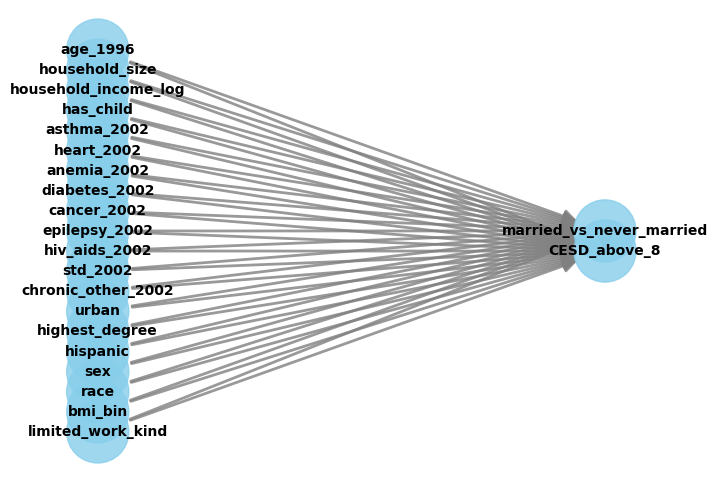

In [266]:
#Create model 
model = CausalModel(
    data=temp_model_data_df,
    treatment=target_treatment,
    outcome=target_outcome,
    common_causes=Xs_numerical + Xs_categorical
)
model.view_model()

identified_estimand = model.identify_effect()

In [267]:
#Estimate using LGBM regressor
estimate = model.estimate_effect(
    identified_estimand=identified_estimand,
    method_name='backdoor.econml.metalearners.SLearner',
    target_units='ate',
    method_params={
    'init_params': {
        'overall_model': LGBMRegressor(
        n_estimators=100, max_depth=20, verbose=0, importance_type='gain')
    },
    'fit_params': {}
    })
print(estimate)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
             d                                                                
───────────────────────────(E[CESD_above_8|bmi_bin,hispanic,household_income_l
d[married_vs_never_married]                                                   

                                                                              
og,sex,heart_2002,race,chronic_other_2002,has_child,urban,age_1996,highest_deg
                                                         

In [268]:
# Get feature importance
feature_importances = estimate.estimator.estimator.overall_model.feature_importances_[1:]
show(pd.DataFrame({'feature':[target_treatment] + Xs_numerical + Xs_categorical,'importance':feature_importances}).sort_values(by='importance',ascending=False))


In [ ]:
#Do refutation
refutation = model.refute_estimate(
    estimand=identified_estimand, 
    estimate=estimate,
    method_name='random_common_cause')
print(refutation)

### Manually create LGBM and do s-learner
Comparing the results if I create the model and use s-learner to calculate manually. Both LGBMClasifier and LGBMRegressor was tested
__Result__
   * Probability decrease of -2.3% for the treated (married)


In [273]:
temp_model_data_df = model_data_df.copy()
temp_model_data_df.dropna(axis=0,subset=target_treatment,inplace=True)
temp_model_data_df = temp_model_data_df.reset_index(drop=True)

In [275]:
X = temp_model_data_df[Xs_numerical + Xs_categorical]
y = temp_model_data_df[target_outcome]
T = temp_model_data_df[target_treatment]

In [294]:
#Create classifier
s_learner = LGBMClassifier(n_estimators=200, max_depth=20,importance_type='gain')
s_learner.fit(pd.concat([X,T],axis=1), y)

#Create prediction output for when T if fixed to 1
X_treated = X.copy()
X_treated[target_treatment] = 1
predicted_outcome_treated = s_learner.predict_proba(X_treated)


#Create prediction output for when T if fixed to 0
X_control = X.copy()
X_control[target_treatment] = 0
predicted_outcome_control = s_learner.predict_proba(X_control)

print('')
print(f'Predicted outcome for treated: {predicted_outcome_treated[:,1].mean():.4f}')
print(f'Predicted outcome for control: {predicted_outcome_control[:,1].mean():.4f}')
print(f'Average treatment effect: {(predicted_outcome_treated[:,1].mean() - predicted_outcome_control[:,1].mean()):.4f}')


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 514, number of negative: 5324
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 323
[LightGBM] [Info] Number of data points in the train set: 5838, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088044 -> initscore=-2.337757
[LightGBM] [Info] Start training from score -2.337757
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't

In [297]:
# Get feature importance
feature_importances = s_learner.feature_importances_
show(pd.DataFrame({'feature':[target_treatment] + X.columns.to_list(),'importance':feature_importances}).sort_values(by='importance',ascending=False))


## Round 2 - T-Learner w/ LGBM, no graphing
Same setup as Round 1 except using T-learner instead
   * __Result__
      * (ATE) Probability decrease of -2.0% for the treated (married), -1.9% when doing by hand
      * Also calculated odds ratio when doing by hand, coming out as 0.79 meaning odds of CESD > 8 decreases by ~21% if married

In [306]:
temp_model_data_df = model_data_df.copy()
temp_model_data_df.dropna(axis=0,subset=target_treatment,inplace=True)
temp_model_data_df = temp_model_data_df.reset_index(drop=True)

In [307]:
#nodes to use
Xs_numerical = ['age_1996','household_size','household_income_log','has_child', 
                'asthma_2002','heart_2002','anemia_2002','diabetes_2002','cancer_2002','epilepsy_2002',
                'hiv_aids_2002','std_2002','chronic_other_2002','urban', 'highest_degree']
Xs_categorical = ['hispanic','sex','race','bmi_bin','limited_work_kind',]


#Although the underlying model (LGBMRegressor) can handle categorical features, it seems the Dowhy or econML wrapper on top can't handle well. 
#Therefore converting them to integers
for col in Xs_categorical: 
    temp_model_data_df[col] = pd.factorize(temp_model_data_df[col])[0]

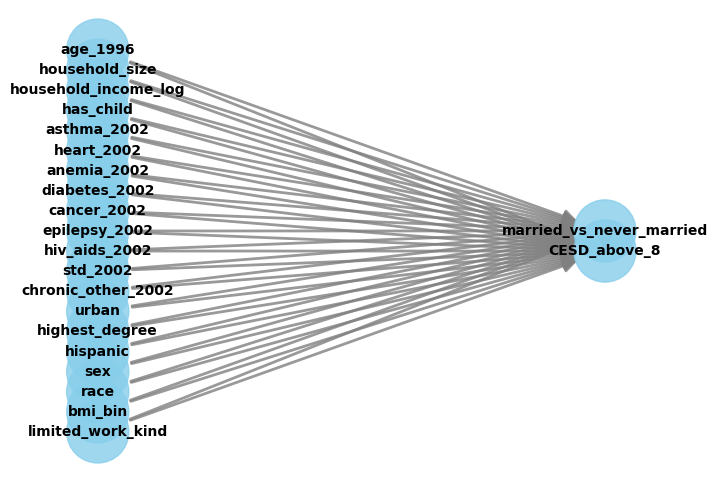

In [308]:
#Create model 
model = CausalModel(
    data=temp_model_data_df,
    treatment=target_treatment,
    outcome=target_outcome,
    common_causes=Xs_numerical + Xs_categorical
)
model.view_model()

# Identify the causal effect, this will only output backdoor as we haven't modeled the causes explicitly
identified_estimand = model.identify_effect()

In [352]:
#Estimate using LGBM regressor
estimate = model.estimate_effect(
    identified_estimand=identified_estimand,
    method_name='backdoor.econml.metalearners.TLearner',
    target_units='ate',
    method_params={
    'init_params': {
        'models': LGBMRegressor(
        n_estimators=200, max_depth=20, num_leaves=50, verbose=0)
    },
    'fit_params': {}
    })
print(estimate)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
             d                                                                
───────────────────────────(E[CESD_above_8|bmi_bin,hispanic,household_income_l
d[married_vs_never_married]                                                   

                                                                              
og,sex,heart_2002,race,chronic_other_2002,has_child,urban,age_1996,highest_deg
                                                                              

                                                                              
ree,anemia_2002,diabetes_2002,household_size,asthma_2002,std_20

In [51]:
refutation = model.refute_estimate(
    estimand=identified_estimand, 
    estimate=estimate,
    method_name='random_common_cause')
print(refutation)

### Manual
Similar to Round 1, doing it manually.

__Results__
   * Average Treatment Effect (ATE): -0.018933951540179943
   * Relative risk: 0.8080409719876679
   * Odds ratio: 0.7914165752236518

In [344]:
temp_model_data_df = model_data_df.copy()
temp_model_data_df.dropna(axis=0,subset=target_treatment,inplace=True)
temp_model_data_df = temp_model_data_df.reset_index(drop=True)

X = temp_model_data_df[Xs_numerical + Xs_categorical]
y = temp_model_data_df[target_outcome]
T = temp_model_data_df[target_treatment]


#Divide data to treated and control
X_treated = X[T.astype(bool)]
y_treated = y[T.astype(bool)]

X_control = X[~T.astype(bool)]
y_control = y[~T.astype(bool)]


#Create separate models for treated and control
model_treated = LGBMClassifier(n_estimators=100, max_depth=10, random_state=42)
model_treated.fit(X_treated, y_treated)

model_control = LGBMClassifier(n_estimators=100, max_depth=10, random_state=42)
model_control.fit(X_control, y_control)

# Predict outcomes for each
Y_hat_treated = model_treated.predict_proba(X)[:, 1]
Y_hat_control = model_control.predict_proba(X)[:, 1]

print("")

# Get ITE and get ATE
ITE = (Y_hat_treated - Y_hat_control)
ATE = np.mean(ITE)
print(f'Average Treatment Effect (ATE): {ATE}')

# Relative risk
print(f'Relative risk: {np.mean(Y_hat_treated) / np.mean(Y_hat_control)}')

# Odds ratio
odds_treated = Y_hat_treated.mean() / (1 - Y_hat_treated).mean()
odds_control = Y_hat_control.mean() / (1 - Y_hat_control).mean()
print(f'Odds ratio: {odds_treated / odds_control}')


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 173, number of negative: 2873
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 312
[LightGBM] [Info] Number of data points in the train set: 3046, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.056796 -> initscore=-2.809820
[LightGBM] [Info] Start training from score -2.809820
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't

## Round 3 - T-Learner w/ LGBM, more variables + graphing
Using T-learner and LGBM here as well, but adding more variables (used for propensity score) and also creating a graph
   * __Result__
      * Probability decrease of -2.4% for the treated (married)


### Graph modeling

In [165]:
nodes = [target_outcome, target_treatment, 'age_1996','household_size','household_income_log','has_child', 
                'asthma_2002','heart_2002','anemia_2002','diabetes_2002','cancer_2002','epilepsy_2002',
                'hiv_aids_2002','std_2002','chronic_other_2002','urban', 'highest_degree',
         'hispanic','sex','race','limited_work_kind',
         'hh_income_1997_log','date_1998','num_days_homework',
         'pct_college_by_30']
edges = []
edges += [(x, target_treatment) for x in ['highest_degree','urban','hh_income_1997_log','race','hispanic','sex','age_1996','date_1998', 'nonresp_parent_in_HH']] 
edges += [(x, target_outcome) for x in ['household_income_log','asthma_2002','heart_2002','anemia_2002','diabetes_2002','cancer_2002','epilepsy_2002',
                'hiv_aids_2002','std_2002','chronic_other_2002','age_1996']]
edges += [(x, 'household_income_log') for x in ['household_size','urban','limited_work_kind','sex']] 
edges += [(target_treatment, target_outcome),
         ('num_days_homework','highest_degree'),
         ('pct_college_by_30','highest_degree'),
         ('nonresp_parent_in_HH','hh_income_1997_log'),
         ('has_child','household_size')
        ]



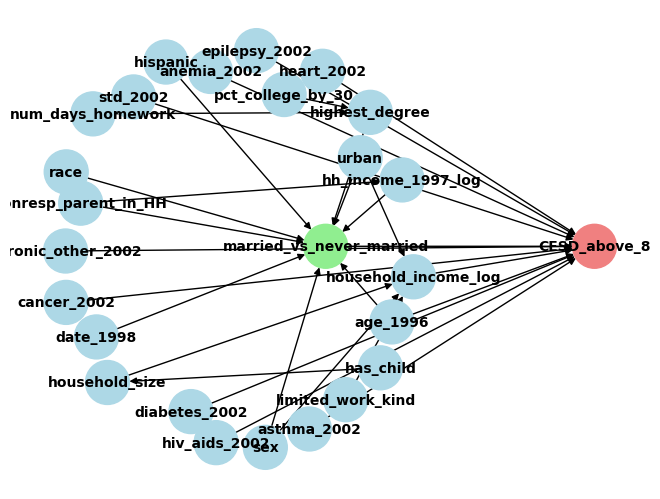

In [167]:
G=nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

pos = nx.spring_layout(G,k=5)  # Position nodes using Fruchterman-Reingold force-directed algorithm
pos[target_outcome] = (2,0)
pos[target_treatment] = (0.5,0)
node_colors = ['lightgreen' if node == target_treatment else 'lightcoral' if node == target_outcome else 'lightblue' for node in G.nodes]

nx.draw(G, pos, with_labels=True,  node_color=node_colors, node_size=1000, font_size=10, font_weight='bold', arrows=True)
plt.show()

### Building & evaluating

In [170]:
temp_model_data_df = model_data_df.copy()
temp_model_data_df.dropna(axis=0,subset=target_treatment,inplace=True)
temp_model_data_df = temp_model_data_df.reset_index(drop=True)

In [172]:
#Create model 
model = CausalModel(
    data=temp_model_data_df,
    treatment=target_treatment,
    outcome=target_outcome,
    graph = "\n".join(nx.generate_gml(G))
)

# Identify the causal effect, this will only output backdoor as we haven't modeled the causes explicitly
identified_estimand = model.identify_effect()

In [178]:
#Estimate using LGBM regressor
estimate = model.estimate_effect(
    identified_estimand=identified_estimand,
    method_name='backdoor.econml.metalearners.TLearner',
    target_units='ate',
    method_params={
    'init_params': {
        'models': LGBMRegressor(
        n_estimators=100, max_depth=10, num_leaves=31, verbose=0)
    },
    'fit_params': {}
    })
print(estimate)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

## Round 4 - Double machine learning
Mostly same setup as Round 3, but using DML (logistic regression for treatment, LGBM for outcome) instead
__Results__
   * Descrease of probability by 2.5%
   * However, getting error of "Co-variance matrix is underdetermined. Inference will be invalid!", which it seems I'm unable to get confidence interval. This may just be due to insufficient sample size compared to # of features, but Will require more analysis. 


### Graph modeling

In [122]:
nodes = [target_outcome, target_treatment, 'age_1996','household_size','household_income_log','has_child', 
                'asthma_2002','heart_2002','anemia_2002','diabetes_2002','cancer_2002','epilepsy_2002',
                'hiv_aids_2002','std_2002','chronic_other_2002','urban', 'highest_degree',
         'hispanic','sex','race','limited_work_kind',
         'hh_income_1997_log','date_1998','num_days_homework',
         'pct_college_by_30']
edges = []
edges += [(x, target_treatment) for x in ['highest_degree','urban','hh_income_1997_log','race','hispanic','sex','age_1996','date_1998', 'nonresp_parent_in_HH']] 
edges += [(x, target_outcome) for x in ['household_income_log','asthma_2002','heart_2002','anemia_2002','diabetes_2002','cancer_2002','epilepsy_2002',
                'hiv_aids_2002','std_2002','chronic_other_2002','age_1996']]
edges += [(x, 'household_income_log') for x in ['household_size','urban','limited_work_kind','sex']] 
edges += [(target_treatment, target_outcome),
         ('num_days_homework','highest_degree'),
         ('pct_college_by_30','highest_degree'),
         ('nonresp_parent_in_HH','hh_income_1997_log'),
         ('has_child','household_size')
        ]



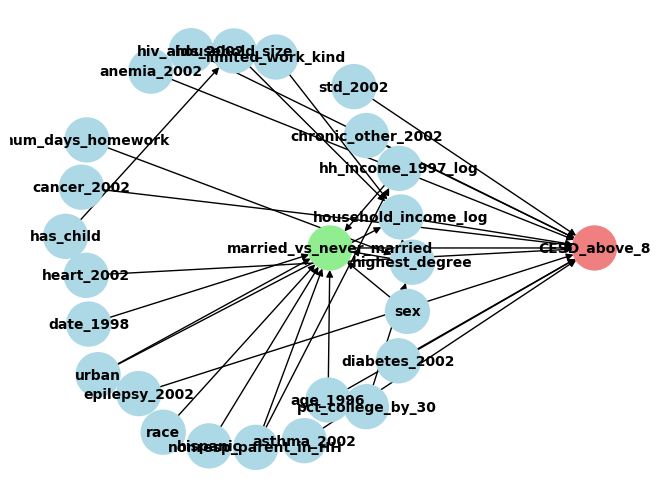

In [124]:
G=nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

pos = nx.spring_layout(G,k=5)  # Position nodes using Fruchterman-Reingold force-directed algorithm
pos[target_outcome] = (2,0)
pos[target_treatment] = (0.5,0)
node_colors = ['lightgreen' if node == target_treatment else 'lightcoral' if node == target_outcome else 'lightblue' for node in G.nodes]

nx.draw(G, pos, with_labels=True,  node_color=node_colors, node_size=1000, font_size=10, font_weight='bold', arrows=True)
plt.show()

### Building & evaluating

In [127]:
temp_model_data_df = model_data_df.copy()
temp_model_data_df.dropna(axis=0,subset=target_treatment,inplace=True)
temp_model_data_df = temp_model_data_df.reset_index(drop=True)

In [129]:
#Create model 
model = CausalModel(
    data=temp_model_data_df,
    treatment=target_treatment,
    outcome=target_outcome,
    graph = "\n".join(nx.generate_gml(G))
)

# Identify the causal effect, this will only output backdoor as we haven't modeled the causes explicitly
identified_estimand = model.identify_effect()

In [195]:
#Estimate using LGBM regressor
estimate = model.estimate_effect(
    identified_estimand=identified_estimand,
    method_name='backdoor.econml.dml.LinearDML',
    target_units='ate',
    method_params={
    'init_params': {
         # Define outcome and treatment models
        'model_y': LGBMRegressor(
        n_estimators=500, max_depth=15),
        'model_t': LogisticRegression(),
        # Specify that treatment is discrete
        'discrete_treatment': True
        },
    'fit_params': {}
    })
print(estimate)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 536
[LightGBM] [Info] Number of data points in the train set: 2919, number of used features: 9
[LightGBM] [Info] Start training from score 0.086331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since

Co-variance matrix is underdetermined. Inference will be invalid!


## backlog
   * Add more features:
      * Health_at_38_39
      * Substance use
   * Make length of marriage as the treatment instead of married VS not 
   * Use more later survey year qs for propensity score calculation
   * Analyze why large feature importance difference between Dowhy+EconML version VS LGBMRegressor by hand
   * Analyze reason of "Co-variance matrix is underdetermined. Inference will be invalid!"

## Playground

In [75]:
target_outcome = 'CESD'

temp_model_data_df = model_data_df.copy()
temp_model_data_df.dropna(axis=0,subset='married_vs_never_married',inplace=True)
Xs_numerical = ['age_1996','household_size','household_income_log','child_1_adopted', 
                'asthma_2002','heart_2002','anemia_2002','diabetes_2002','cancer_2002','epilepsy_2002',
                'hiv_aids_2002','std_2002','chronic_other_2002','urban', 'highest_degree']
Xs_categorical = ['hispanic','sex','race','bmi_bin','limited_work_kind',]

for col in Xs_categorical: 
    temp_model_data_df[col] = pd.factorize(temp_model_data_df[col])[0]


X = temp_model_data_df[Xs_numerical + Xs_categorical]
y = temp_model_data_df[target_outcome]
T = temp_model_data_df[target_treatment]
#Create model 
model = CausalModel(
    data=temp_model_data_df,
    treatment=target_treatment,
    outcome=target_outcome,
    common_causes=Xs_numerical + Xs_categorical
)

# Identify the causal effect, this will only output backdoor as we haven't modeled the causes explicitly
identified_estimand = model.identify_effect()

#Estimate using LGBM regressor
estimate = model.estimate_effect(
    identified_estimand=identified_estimand,
    method_name='backdoor.econml.metalearners.TLearner',
    target_units='ate',
    method_params={
    'init_params': {
        'models': LGBMRegressor(
        n_estimators=500, max_depth=20, num_leaves=50, verbose=0)
    },
    'fit_params': {}
    })
print(estimate)

target_outcome = 'CESD_above_8'


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
             d                                                                
───────────────────────────(E[CESD|bmi_bin,hispanic,household_income_log,sex,h
d[married_

In [76]:
target_outcome = 'CESD'
nodes = [target_outcome, target_treatment, 'age_1996','household_size','household_income_log','child_1_adopted', 
                'asthma_2002','heart_2002','anemia_2002','diabetes_2002','cancer_2002','epilepsy_2002',
                'hiv_aids_2002','std_2002','chronic_other_2002','urban', 'highest_degree',
         'hispanic','sex','race','limited_work_kind',
         'hh_income_1997_log','date_1998','num_days_homework',
         'pct_college_by_30']
edges = [(target_treatment, target_outcome),
         ('num_days_homework','highest_degree'),
         ('pct_college_by_30','highest_degree'),
         ('nonresp_parent_in_HH','hh_income_1997_log'),
         ('child_1_adopted','household_size')
        ]
edges += [(x, 'household_income_log') for x in ['household_size','urban','limited_work_kind','sex']] 
edges += [(x, target_treatment) for x in ['urban','hh_income_1997_log','race','hispanic','sex','age_1996','date_1998']] 
edges += [(x, target_outcome) for x in ['household_income_log','asthma_2002','heart_2002','anemia_2002','diabetes_2002','cancer_2002','epilepsy_2002',
                'hiv_aids_2002','std_2002','chronic_other_2002','age_1996']]
G=nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

pos = nx.spring_layout(G,k=5)  # Position nodes using Fruchterman-Reingold force-directed algorithm
pos[target_outcome] = (2,0)
pos[target_treatment] = (0.5,0)
node_colors = ['lightgreen' if node == target_treatment else 'lightcoral' if node == target_outcome else 'lightblue' for node in G.nodes]
temp_model_data_df = model_data_df.copy()
temp_model_data_df.dropna(axis=0,subset='married_vs_never_married',inplace=True)
temp_model_data_df = temp_model_data_df.reset_index(drop=True)
X_cols = nodes.copy()
X_cols.remove(target_outcome)
X_cols.remove(target_treatment)
X = temp_model_data_df[X_cols]
y = temp_model_data_df[target_outcome]
T = temp_model_data_df[target_treatment]
#Create model 
model = CausalModel(
    data=temp_model_data_df,
    treatment=target_treatment,
    outcome=target_outcome,
    graph = "\n".join(nx.generate_gml(G))
)

# Identify the causal effect, this will only output backdoor as we haven't modeled the causes explicitly
identified_estimand = model.identify_effect()

#Estimate using LGBM regressor
estimate = model.estimate_effect(
    identified_estimand=identified_estimand,
    method_name='backdoor.econml.metalearners.XLearner',
    target_units='ate',
    method_params={
    'init_params': {
        'models': [
            LGBMRegressor(n_estimators=500, max_depth=20, num_leaves=50, verbose=0),
            LGBMRegressor(n_estimators=500, max_depth=20, num_leaves=50, verbose=0)
        ],
        'cate_models': [
            LGBMRegressor(n_estimators=500, max_depth=20, num_leaves=50, verbose=0),
            LGBMRegressor(n_estimators=500, max_depth=20, num_leaves=50, verbose=0)
        ]
    },
    'fit_params': {}
    })
print(estimate)

target_outcome = 'CESD_above_8'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [77]:
temp_model_data_df = model_data_df.copy()
temp_model_data_df.dropna(axis=0,subset=target_treatment,inplace=True)
temp_model_data_df = temp_model_data_df.reset_index(drop=True)
Xs_numerical = ['age_1996','household_size','household_income_log', 
#                'asthma_2002','heart_2002','anemia_2002','diabetes_2002','cancer_2002','epilepsy_2002',
#                'hiv_aids_2002','std_2002','chronic_other_2002','urban', 'highest_degree']
               ]
Xs_categorical = ['hispanic','sex','race']

for col in Xs_categorical: 
    temp_model_data_df[col] = pd.factorize(temp_model_data_df[col])[0]
#Create model 
model = CausalModel(
    data=temp_model_data_df,
    treatment=target_treatment,
    outcome=target_outcome,
    common_causes=Xs_numerical + Xs_categorical
)

identified_estimand = model.identify_effect()

#Estimate using Logistic regressor
estimate = model.estimate_effect(
    identified_estimand=identified_estimand,
#    method_name="backdoor.linear_regression",
    method_name="backdoor.generalized_linear_model",
       confidence_intervals=False,
       test_significance=False,
    method_params = {
        'num_null_simulations':10,
        'num_simulations':10,
        'num_quantiles_to_discretize_cont_cols':10,
        'fit_method': "statsmodels",
        'glm_family': sm.families.Binomial(), # logistic regression
        'need_conditional_estimates':False
    },
   
    target_units='ate',
)
print(estimate)


print('-------------------------------------------------------')
X = temp_model_data_df[Xs_numerical + Xs_categorical]
y = temp_model_data_df[target_outcome]
T = temp_model_data_df[target_treatment]

lm = LogisticRegression()
model = lm.fit(pd.concat([X,T],axis=1), y)
print(model.coef_)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
             d                                                                
───────────────────────────(E[CESD_above_8|hispanic,household_income_log,sex,a
d[married_vs_never_married]                                                   

                             
ge_1996,household_size,race])
                             
Estimand assumption 1, Unconfoundedness: If U→{married_vs_never_married} and U→CESD_above_8 then P(CESD_above_8|married_vs_never_married,hispanic,household_income_log,sex,age_1996,household_size,race,U) = P(CESD_above_8|married_vs_never_married,hispanic,household_income_log,sex,age_1996,household_size,race)

## Realized estimand
b: CESD_above_8~Sigmoid(married_vs_never_married+hispanic+household_income_log+sex+age_1996+household_size+race)
Target units: ate

## Estimate
Mean value: -0.05902932652730448

------

In [78]:
print(estimate.estimator.model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           CESD_above_8   No. Observations:                 5838
Model:                            GLM   Df Residuals:                     5830
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1642.4
Date:                Wed, 14 Aug 2024   Deviance:                       3284.8
Time:                        09:08:59   Pearson chi2:                 5.84e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.03276
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9560      0.501     -3.903      0.0

In [79]:
 estimate.estimator.model

In [80]:
(o1[:,1] - o0[:,1]).mean()

NameError: name 'o1' is not defined

In [81]:
X0 = X.assign(married_vs_never_married=0)
X0 = sm.add_constant(X0)
X1 = X.assign(married_vs_never_married=1)
X1 = sm.add_constant(X1,has_constant='add')

o0 = estimate.estimator.model.model.predict(X0.transpose())
o1 = estimate.estimator.model.model.predict(X1.transpose())
print(f'o0: {o0[:,1].mean()}')
print(f'o1: {o1[:,1].mean()}')
print(f'diff: {o1[:,1].mean()- o0[:,1].mean()}')


o0: 0.9999999199693596
o1: 0.9999999490856307
diff: 2.9116271171858443e-08


,age_1996,household_size,household_income_log,hispanic,sex,race,married_vs_never_married
0,14,2,12.148751,0,0,0,0
1,13,5,0.000000,0,1,0,0
2,15,2,0.000000,0,1,0,0
3,14,5,0.000000,0,0,1,0
4,14,4,11.112463,0,1,0,0
...,...,...,...,...,...,...,...
5833,14,4,10.950824,1,1,2,0
5834,16,2,10.915343,1,1,1,0
5835,12,2,10.511295,0,0,0,0
5836,16,1,11.082158,1,0,1,0
